<a href="https://colab.research.google.com/github/willycornelissen/calendar/blob/master/AIR_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Imports

#General
import numpy as np
import itertools

# System
import os, fnmatch

# Data
import pandas as pd

# Visualization
import seaborn 
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display, Image

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report


# Deep Learning
import tensorflow as tf
from tensorflow.python.client import device_lib 
from keras.backend.tensorflow_backend import set_session
from tensorflow.python.client import device_lib
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, merge
from keras.layers.normalization import BatchNormalization
from keras.callbacks import History, EarlyStopping, ModelCheckpoint
from keras.models import load_model


# Random Seed
from tensorflow import set_random_seed
from numpy.random import seed
seed(0)
set_random_seed(0)

# Audio
import librosa.display, librosa
from librosa.util import normalize as normalize
import IPython.display as ipd

# Configurations
path='./audio/london_phill_dataset_multi/'

# Display CPUs and GPUs
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13748715227969224317
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4751120740219162023
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 487958461598850976
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14773796864
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3850373943981128470
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
# Only for Google Colab
try:
    import google.colab
    if "GPU:0" in tf.test.gpu_device_name():
        !nvidia-smi
        config = tf.ConfigProto(log_device_placement=True, allow_soft_placement=True, device_count = {'GPU': 0})
        config.gpu_options.allow_growth = True
        session = tf.Session(config=config)
        set_session(session)
    else:
        print("No GPU Detected. Configure the Runtime.")
    # !git clone https://github.com/GuitarsAI/BasicsMusicalInstrumClassifi
    # !unzip ./BasicsMusicalInstrumClassifi/audio/*.zip -d ./BasicsMusicalInstrumClassifi/audio
    path="./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/"
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    tf.logging.set_verbosity(tf.logging.ERROR)
    from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
    
except Exception as e:
    print("Not inside Google Colab: %s. Using standard configurations." % (e))
    !cat /proc/cpuinfo

Mon Aug 12 17:59:10 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |    248MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Signal Processing Parameters
fs = 44100         # Sampling Frequency
n_fft = 2048       # length of the FFT window
hop_length = 512   # Number of samples between successive frames


# Machine Learning Parameters
testset_size = 0.25 #Percentage of data for Testing

In [7]:

# Function to Display a Website
display(HTML("<style>.container { width:80% !important; }</style>"))
def show_web(url):
    html_code='<center><iframe src="%s" width="800" height="600" frameborder="0" marginheight="0" marginwidth="0">Loading...</iframe></center>' \
		% (url)
    display(HTML(html_code))

In [8]:
#Find Audio Files
files = []
labels =[]
duration = []
classes=['flute','sax','oboe', 'cello','trumpet','viola']
for root, dirnames, filenames in os.walk(path):
    for i, filename in enumerate(fnmatch.filter(filenames, '*.mp3')):
        files.append(os.path.join(root, filename))
        for name in classes:
            if fnmatch.fnmatchcase(filename, '*'+name+'*'):
                labels.append(name)
                break
        else:
            labels.append('other')
        print ("Get %d = %s"%(i+1, filename))
        try:
            y, sr = librosa.load(files[i], sr=fs)
            if len(y) < 2:
                print("Error loading %s" % filename)
                continue
            #y/=y.max() #Normalize
            yt, index = librosa.effects.trim(y,top_db=60) #Trim
            duration.append(librosa.get_duration(yt, sr=fs))
        except Exception as e:
            print("Error loading %s. Error: %s" % (filename,e))


print("found %d audio files in %s"%(len(files),path))

Get 1 = flute_A4_15_mezzo-piano_normal.mp3
Get 2 = flute_Gs5_1_forte_normal.mp3
Get 3 = flute_Gs6_15_mezzo-forte_normal.mp3
Get 4 = flute_Gs5_05_mezzo-forte_normal.mp3
Get 5 = flute_A6_1_forte_normal.mp3
Get 6 = flute_Gs6_15_piano_normal.mp3
Get 7 = flute_Gs5_15_forte_normal.mp3
Get 8 = flute_Gs5_15_mezzo-forte_normal.mp3
Get 9 = flute_Gs4_05_piano_normal.mp3
Get 10 = flute_A4_15_piano_normal.mp3
Get 11 = flute_A5_15_pianissimo_normal.mp3
Get 12 = flute_Gs4_15_mezzo-piano_normal.mp3
Get 13 = flute_Gs6_025_mezzo-forte_normal.mp3
Get 14 = flute_Gs5_05_piano_normal.mp3
Get 15 = flute_A6_1_fortissimo_minor-trill.mp3
Get 16 = flute_Gs5_1_mezzo-forte_normal.mp3
Get 17 = flute_Gs6_1_pianissimo_normal.mp3
Get 18 = flute_A5_1_pianissimo_normal.mp3
Get 19 = flute_A4_05_piano_normal.mp3
Get 20 = flute_A4_05_mezzo-piano_normal.mp3
Get 21 = flute_A4_1_pianissimo_normal.mp3
Get 22 = flute_A5_05_pianissimo_normal.mp3
Get 23 = flute_Gs6_15_forte_normal.mp3
Get 24 = flute_Gs6_05_pianissimo_normal.mp3
G

In [9]:

print("Max. Duration:", max(duration))
print("Min. Duration:", min(duration))
print("Average Duration:", np.mean(duration))

Max. Duration: 2.078185941043084
Min. Duration: 0.23510204081632652
Average Duration: 0.8970448979591837


In [11]:
# Load audio files, trim silence and calculate duration
duration = []
for i,f in enumerate(files):
    print ("Get %d  %s"%(i+1, f))
    try:
        y, sr = librosa.load(f, sr=fs)
        if len(y) < 2:
            print("Error loading %s" % f)
            continue
        #y/=y.max() #Normalize
        yt, index = librosa.effects.trim(y,top_db=60) #Trim
        duration.append(librosa.get_duration(yt, sr=fs))
    except Exception as e:
        print("Error loading %s. Error: %s" % (f,e))
        
print("Calculated %d Durations"%len(duration))

Get 1  ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_A4_15_mezzo-piano_normal.mp3
Get 2  ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_Gs5_1_forte_normal.mp3
Get 3  ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_Gs6_15_mezzo-forte_normal.mp3
Get 4  ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_Gs5_05_mezzo-forte_normal.mp3
Get 5  ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_A6_1_forte_normal.mp3
Get 6  ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_Gs6_15_piano_normal.mp3
Get 7  ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_Gs5_15_forte_normal.mp3
Get 8  ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_Gs5_15_mezzo-forte_normal.mp3
Get 9  ./BasicsMusicalInstrumClassifi/audio/london_phill_dataset_multi/flute/flute_Gs4_05_piano_normal.mp3
Get 10  ./BasicsM

Duration average: 1.0032761904761904


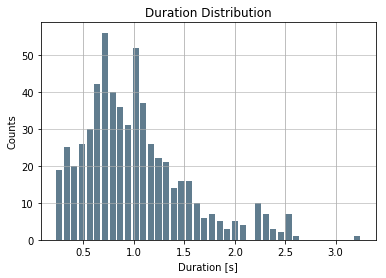

In [12]:

durationDist = pd.Series(np.array(duration))
plt.figure()
durationDist.plot.hist(grid=True, bins=40, rwidth=0.8,
                   color='#607c8e')
plt.title('Duration Distribution')
plt.xlabel('Duration [s]')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)
print("Duration average:",np.mean(duration))

Spectogram Array Shape: (1025, 87)


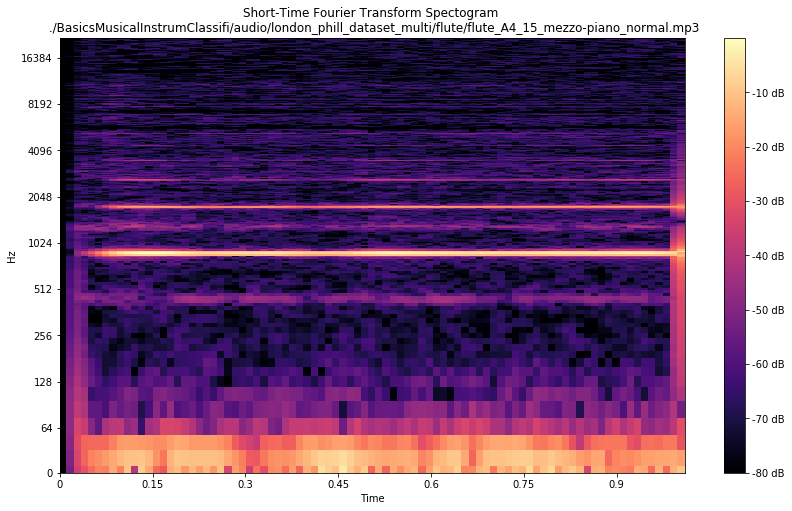

In [13]:
# STFT Example
y, sr = librosa.load(files[10], sr=fs, duration=1)
y/=y.max() #Normalize
duration_in_samples=librosa.time_to_samples(1, sr=fs)
y_pad = librosa.util.fix_length(y, duration_in_samples) #Pad to 1s if smaller
y_stft=librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
y_spec=librosa.amplitude_to_db(abs(y_stft), np.max)
plt.figure(figsize=(14,8))
plt.title("Short-Time Fourier Transform Spectogram \n %s"%files[0])
librosa.display.specshow(y_spec,sr=fs,y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB');
print("Spectogram Array Shape:",y_spec.shape)
ipd.Audio(y, rate=fs)

In [14]:
# Encode Labels
labelencoder = LabelEncoder()
labelencoder.fit(labels)
print(len(labelencoder.classes_), "classes:", ", ".join(list(labelencoder.classes_)))
classes_num = labelencoder.transform(labels)

#OneHotEncoding
encoder=OneHotEncoder(sparse=False, categories="auto")
onehot_labels=encoder.fit_transform(classes_num.reshape(len(classes_num),1))

6 classes: cello, flute, oboe, sax, trumpet, viola


In [0]:
# Create Train and Test Sets
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=0)
splits = splitter.split(files, onehot_labels)
files_arr=np.array(files)

for train_index, test_index in splits:
    train_set_files = files_arr[train_index]
    test_set_files = files_arr[test_index]
    train_classes = onehot_labels[train_index]
    test_classes = onehot_labels[test_index]

In [0]:
# CNN Model
model = Sequential()

conv_filters =  16  # number of convolution filters

# Layer 1
model.add(Convolution2D(conv_filters, 3,input_shape=(1025, 87, 1)))
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.40)) 

# Layer 2
model.add(Convolution2D(conv_filters, 3))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

# Flatten
model.add(Flatten()) 

# Full layer
model.add(Dense(16, activation='sigmoid')) 

# Output layer
model.add(Dense(6,activation='softmax'))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1023, 85, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 511, 42, 16)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 511, 42, 16)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 509, 40, 16)       2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 254, 20, 16)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 254, 20, 16)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 81280)             0         
__________

In [0]:
# Loss Function 
loss = 'categorical_crossentropy' 

# Optimizer = Gradient Descent
optimizer = 'sgd' 

# Compile
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [0]:
def featureGenerator(files, labels):
    while True:
        for i,f in enumerate(files):
            try:
                feature_vectors = []
                label = []
                y, sr = librosa.load(f, sr=fs)
                if len(y) < 2:
                    print("Error loading %s" % f)
                    continue
                y, index = librosa.effects.trim(y,top_db=60) #Trim
                y = normalize(y)
                duration_in_samples=librosa.time_to_samples(1, sr=fs)
                y_pad = librosa.util.fix_length(y, duration_in_samples) #Pad/Trim to same duration
                y_stft=librosa.core.stft(y_pad, n_fft=n_fft, hop_length=hop_length)
                y_spec=librosa.amplitude_to_db(abs(y_stft), np.min)
                scaler = StandardScaler()
                dtype = K.floatx()
                data = scaler.fit_transform(y_spec).astype(dtype)
                data = np.expand_dims(data, axis=0)
                data = np.expand_dims(data, axis=3)
                feature_vectors.append(data)
                label.append([labels[i]])
                yield feature_vectors, label
            except Exception as e:
                print("Error loading %s. Error: %s" % (f,e))
                raise
                break

In [20]:
%%time
hist = History();
es = EarlyStopping(monitor='val_acc', min_delta=0.01, restore_best_weights=True, patience= 10, verbose=1 )
mc = ModelCheckpoint('best_model.h5', monitor='val_acc',save_best_only=True, verbose=1)


try:
    import google.colab
    tbc=TensorBoardColab()
    callbacksKeras=[hist,es,mc,TensorBoardColabCallback(tbc)]

except Exception as e:
    callbacksKeras=[hist,es,mc]
    print("Not inside Google Colab: %s. Using standard configurations." % (e))


model.fit_generator(featureGenerator(train_set_files, train_classes), 
                    validation_data=(featureGenerator(test_set_files, test_classes)), 
                    validation_steps=150, 
                    steps_per_epoch=450,epochs=30,callbacks=callbacksKeras, verbose=1)

Wait for 8 seconds...
TensorBoard link:
https://58f457fd.ngrok.io
Epoch 1/30
450/450 [==============================] - 154s 342ms/step - loss: 1.1991 - acc: 0.6178 - val_loss: 0.8971 - val_acc: 0.7200

Epoch 00001: val_acc improved from -inf to 0.72000, saving model to best_model.h5
Epoch 2/30
450/450 [==============================] - 152s 338ms/step - loss: 0.5867 - acc: 0.8644 - val_loss: 0.5632 - val_acc: 0.8933

Epoch 00002: val_acc improved from 0.72000 to 0.89333, saving model to best_model.h5
Epoch 3/30
450/450 [==============================] - 152s 337ms/step - loss: 0.3548 - acc: 0.9533 - val_loss: 0.3318 - val_acc: 0.9733

Epoch 00003: val_acc improved from 0.89333 to 0.97333, saving model to best_model.h5
Epoch 4/30
450/450 [==============================] - 153s 339ms/step - loss: 0.2251 - acc: 0.9800 - val_loss: 0.2594 - val_acc: 0.9800

Epoch 00004: val_acc improved from 0.97333 to 0.98000, saving model to best_model.h5
Epoch 5/30
450/450 [=============================

In [0]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss')
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss')
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

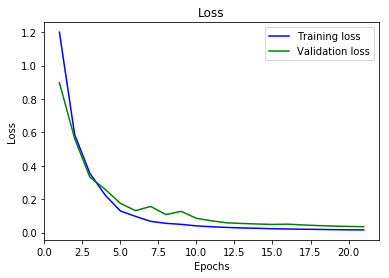

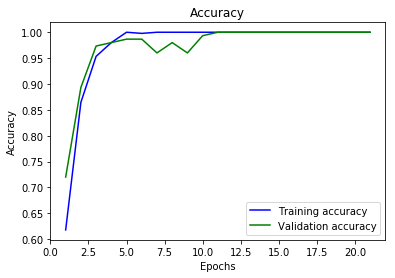

In [23]:

plot_history(hist)

In [24]:

saved_model = load_model('best_model.h5')
test_pred = saved_model.predict_generator(featureGenerator(test_set_files, test_classes), steps=150,verbose=1)

150/150 [==============================] - 35s 230ms/step


In [0]:

predictions_round=np.around(test_pred).astype('int');
predictions_int=np.argmax(predictions_round,axis=1);
predictions_labels=labelencoder.inverse_transform(np.ravel(predictions_int));

In [27]:

# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(classes_num[test_index], predictions_int,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(classes_num[test_index], predictions_int,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(classes_num[test_index], predictions_int, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(classes_num[test_index], predictions_int,normalize=True), accuracy_score(classes_num[test_index], predictions_int,normalize=False) )
print("Number of samples:",classes_num[test_index].shape[0])

print(classification_report(classes_num[test_index], predictions_int))

Recall:  [1. 1. 1. 1. 1. 1.]
Precision:  [1. 1. 1. 1. 1. 1.]
F1-Score:  [1. 1. 1. 1. 1. 1.]
Accuracy: 1.00  , 150
Number of samples: 150
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25
           2       1.00      1.00      1.00        25
           3       1.00      1.00      1.00        25
           4       1.00      1.00      1.00        25
           5       1.00      1.00      1.00        25

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



In [0]:

# Compute confusion matrix
cnf_matrix = confusion_matrix(classes_num[test_index], predictions_int)
np.set_printoptions(precision=2)

In [0]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

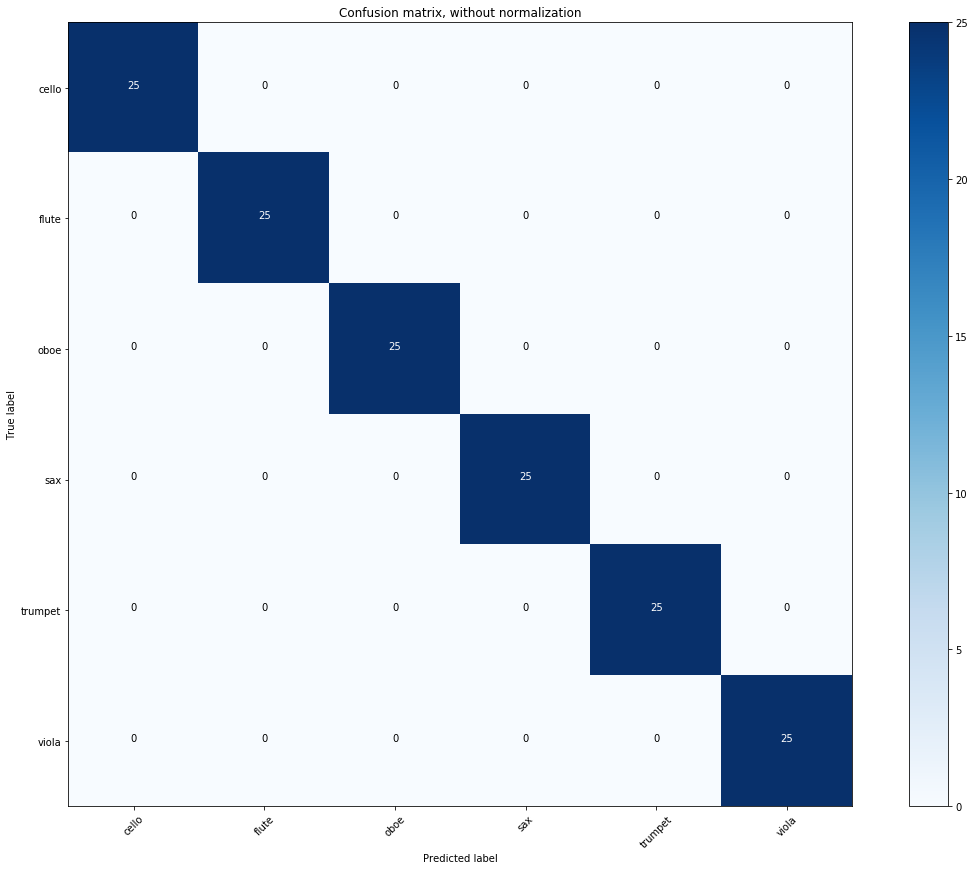

In [30]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(16,12))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix, without normalization')

In [0]:
# Find wrong predicted samples indexes
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(classes_num[test_index], predictions_int)) if e1 != e2]

In [32]:
# Find wrong predicted audio files
print(np.array(labels)[test_index[wrong_predictions]])
print(predictions_labels[wrong_predictions].T)
print(np.array(files)[test_index[wrong_predictions]])

[]
[]
[]
